In [1]:
from gravipy.tensorial import *
from sympy import *

Schwarzschild計量のChristoffel記号を計算する。
[gravipy](https://github.com/wojciechczaja/GraviPy)を使う。

レポジトリのdocsディレクトリにあるチュートリアル用ipnbファイルを参考にした。

In [2]:
t, r, theta, phi, M = symbols('t, r, \\theta, \phi, M')
x = Coordinates('\chi', [t, r, theta, phi])
Metric = diag(-(1-2*M/r), 1/(1-2*M/r), r**2, r**2*sin(theta)**2)  #Schwarzschild計量
g = MetricTensor('g', x, Metric)
Ga = Christoffel('Ga', g)

In [3]:
#計量テンソル
g(All, All)

Matrix([
[2*M/r - 1,              0,    0,                   0],
[        0, 1/(-2*M/r + 1),    0,                   0],
[        0,              0, r**2,                   0],
[        0,              0,    0, r**2*sin(\theta)**2]])

In [4]:
#Christoffel記号
Ga(-All, All, All) 

Matrix([[Matrix([
[               0, -M/(r*(2*M - r)), 0, 0],
[-M/(r*(2*M - r)),                0, 0, 0],
[               0,                0, 0, 0],
[               0,                0, 0, 0]]), Matrix([
[M*(-2*M + r)/r**3,                              0,       0,                          0],
[                0, -M*(-2*M + r)/(r*(2*M - r)**2),       0,                          0],
[                0,                              0, 2*M - r,                          0],
[                0,                              0,       0, -(-2*M + r)*sin(\theta)**2]]), Matrix([
[0,   0,   0,                0],
[0,   0, 1/r,                0],
[0, 1/r,   0,                0],
[0,   0,   0, -sin(2*\theta)/2]]), Matrix([
[0,   0,                                0,                                0],
[0,   0,                                0,                              1/r],
[0,   0,                                0, sin(2*\theta)/(2*sin(\theta)**2)],
[0, 1/r, sin(2*\theta)/(2*sin(\theta)**2),     

次に測地線方程式による四元加速度
$$
a^{\lambda}  = \frac{d^2x^{\lambda}}{d\tau^2}= -\Gamma^{\lambda}_{\mu \nu} \frac{dx^{\mu}}{d\tau} \frac{dx^{\nu}}{d\tau} =  -\Gamma^{\lambda}_{\mu \nu} v^{\mu}v^{\nu}
$$
を計算する。ここで$\tau$は何らかのパラメータである(固有時ではない)。

In [5]:
from itertools import product
var("v_0, v_1, v_2, v_3")
var("a_0, a_1, a_2, a_3")
a_list = [a_0, a_1, a_2, a_3]
v_list = [v_0, v_1, v_2, v_3]
for i in range(4):
    a_list[i] = 0

#縮約を取る
for i, j, k in product(range(4), repeat=3):
    a_list[i] -= Ga( -i-1, j + 1, k + 1)*v_list[j]*v_list[k]

In [6]:
for i in range(4):
    display(a_list[i])

2*M*v_0*v_1/(r*(2*M - r))

M*v_1**2*(-2*M + r)/(r*(2*M - r)**2) - M*v_0**2*(-2*M + r)/r**3 - v_2**2*(2*M - r) + v_3**2*(-2*M + r)*sin(\theta)**2

v_3**2*sin(2*\theta)/2 - 2*v_1*v_2/r

-v_2*v_3*sin(2*\theta)/sin(\theta)**2 - 2*v_1*v_3/r

実行速度の観点からsympy数式から関数へ変換する。

参考:https://docs.sympy.org/latest/modules/utilities/lambdify.html

In [7]:
from sympy.utilities.lambdify import lambdify
a_func = lambdify((t, r, theta, phi, M, v_0, v_1, v_2, v_3), a_list)

位置と速度の四元ベクトル$x^\mu, v^\mu$を入力すると四元加速度$a^\mu$を返す関数を定義する。

In [8]:
import numpy as np
a = lambda x, v: np.array(a_func(x[0], x[1], x[2], x[3], 1, v[0], v[1], v[2], v[3]))

時間発展はRunge–Kutta法([wikipedia](https://ja.wikipedia.org/wiki/%E3%83%AB%E3%83%B3%E3%82%B2%EF%BC%9D%E3%82%AF%E3%83%83%E3%82%BF%E6%B3%95))で計算する。

ニュートン運動方程式のRunge–Kutta法によるシュミレーションを参考にした。

https://www.compadre.org/PICUP/resources/Numerical-Integration/


今解きたい問題は、

$$
\begin{align}
&\frac{dv^\mu}{d\tau} = a^\mu(x^\mu, v^\mu)\\
&\frac{dx^\mu}{d\tau} = v^\mu
\end{align}
$$
であるので、
$$
\begin{align}
&k^\mu_{1v} = a^\mu(x^\mu, v^\mu)d\tau \\
&k^\mu_{1x} = av^\mu d\tau \\
&k^\mu_{2v} = a^\mu(x^\mu + \frac{k^\mu_{1x}}{2}, v^\mu+ \frac{k^\mu_{1v}}{2})d\tau \\
&k^\mu_{2x} = ( v^\mu+ \frac{k^\mu_{1v}}{2})d\tau \\
&k^\mu_{3v} = a^\mu(x^\mu + \frac{k^\mu_{2x}}{2}, v^\mu+ \frac{k^\mu_{2v}}{2})d\tau\\
&k^\mu_{3x} = ( v^\mu+ \frac{k^\mu_{2v}}{2})d\tau\\
&k^\mu_{4v} = a^\mu(x^\mu + k^\mu_{3x}, v^\mu + k^\mu_{3v})d\tau\\
&k^\mu_{4x} = (v^\mu + k^\mu_{3v})d\tau\\
\end{align}
$$
を計算して、$x^\mu$, $v^\mu$を
$$
\begin{align}
x^\mu_{\mathrm{next}} = x^\mu + \frac{1}{6}(k^\mu_{1x} + 2k^\mu_{2x} + 2k^\mu_{3x} + k^\mu_{4x}) \\
v^\mu_{\mathrm{next}} = v^\mu + \frac{1}{6}(k^\mu_{1v} + 2k^\mu_{2v} + 2k^\mu_{3v} + k^\mu_{4v})
\end{align}
$$
と更新していけば良い。ニュートン運動方程式で$t$に相当するのがパラメータ$\tau$であることに注意。

In [9]:
N = 10**5 #計算ステップ数
x = np.array([0.0, 17.32050808,  0.95531662, -0.78539816]) 
#初期位置は適当に決める。M=1がSchwarzschild半径なのでrはそれよりは大きくする
v = np.array([1, -0.02886728, -0.00824957,  0.01750001]) 
#t=0付近で\tau=tと選ぶとdt/d\tau = 1なので時間成分の速さは1にする
# 空間成分の速度は適当。

dtau = 0.1 #1ステップごとに進む\tau幅
R = [] 
Theta = []
Phi = []
T = []
for _ in range(N):
    T.append(x[0])
    R.append(x[1])
    Theta.append(x[2])
    Phi.append(x[3])
    k1v = a(x, v)*dtau
    k1x = v*dtau
    k2v = a(x+k1x/2, v+k1v/2)*dtau
    k2x = (v+k1v/2)*dtau
    k3v = a(x+k2x/2, v+k2v/2)*dtau
    k3x = (v+k2v/2)*dtau
    k4v = a(x+k3x, v+k3v)*dtau
    k4x = (v+k3v)*dtau
    v = v + (1/6)*(k1v+2*k2v+2*k3v+k4v)
    x = x + (1/6)*(k1x+2*k2x+2*k3x+k4x)
X = R*np.cos(Phi)*np.sin(Theta)
Y = R*np.sin(Phi)*np.sin(Theta)
Z = R*np.cos(Theta)

今、謎のパラメータ$\tau$で$x$, $y$, $z$がパラメーター付けされているので、$t$によるパラメータ付けに変えたい。時系列データの補間を行う。

参考：
https://qiita.com/kenichi-hamaguchi/items/3c5e63e195e06a21d1da

In [10]:
dt = 10 #時間幅
T_new = np.arange(0, T[-1], dt)
X_new = np.interp(T_new, T, X)
Y_new = np.interp(T_new, T, Y)
Z_new = np.interp(T_new, T, Z)

アニメーションを実装する。

<IPython.core.display.Javascript object>


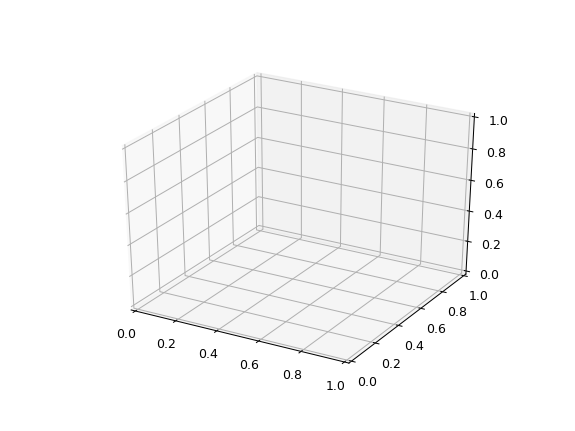

In [11]:
%matplotlib nbagg
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
L = 50 #空間のサイズ
def update(i):
    if i != 0:
        ax.clear()
    ax.scatter(0, 0, 0, marker="o", c="orange", s=100)
    ax.plot(X_new[:i], Y_new[:i], Z_new[:i], c="black", alpha = 0.4)
    ax.scatter(X_new[i], Y_new[i], Z_new[i], marker="o", c="blue", s=10)
    ax.set_title(r"$t=$"+str(int(T_new[i])))
    ax.view_init(elev=30, azim=225)
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_zlim(-L, L)

ani = animation.FuncAnimation(fig, update, frames=len(T_new), interval=1)

Kerr計量の場合

In [12]:
t, r, theta, phi, M, a, rhosq, Delta = symbols('t, r, theta, phi, M, a, rhosq, Delta')
chi = Coordinates('\chi', [t, r, theta, phi])

rhosq = r**2+(a**2)*cos(theta)**2
Delta = r**2-2*M*r+a**2

Metric = Matrix([[(1-(2*M*r)/rhosq),0,0,(2*a*M*r*sin(theta)**2)/rhosq], \
[0,-rhosq/Delta,0,0], [0,0,-rhosq,0], [(2*a*M*r*sin(theta)**2)/rhosq,0,0, \
-(sin(theta)**2)*((r**2+a**2)+(2*(a**2)*M*r*sin(theta)**2)/rhosq)]])

# 結構時間かかる
g = MetricTensor('g', chi, Metric)
Ga = Christoffel('Ga', g)
var("v_0, v_1, v_2, v_3")
var("a_0, a_1, a_2, a_3")
a_list = [a_0, a_1, a_2, a_3]
v_list = [v_0, v_1, v_2, v_3]
for i in range(4):
    a_list[i] = 0

#縮約を取る
for i, j, k in product(range(4), repeat=3):
    a_list[i] -= Ga( -i-1, j + 1, k + 1)*v_list[j]*v_list[k]

In [13]:
a_func = lambdify((t, r, theta, phi, a, M, v_0, v_1, v_2, v_3), a_list)
# a = 0.8, M = 1で計算
a_kerr = lambda x, v: np.array(a_func(x[0], x[1], x[2], x[3], 0.8, 1, v[0], v[1], v[2], v[3]))

In [14]:
N = 10**4 #計算ステップ数
x = np.array([0.0, 17.32050808,  0.95531662, -0.78539816]) 
#初期位置は適当に決める。M=1がSchwarzschild半径なのでrはそれよりは大きくする
v = np.array([1, -0.02886728, -0.00824957,  0.01750001]) 
#t=0付近で\tau=tと選ぶとdt/d\tau = 1なので時間成分の速さは1にする
# 空間成分の速度は適当。

dtau = 0.5 #1ステップごとに進む\tau幅
R = [] 
Theta = []
Phi = []
T = []
for _ in range(N):
    T.append(x[0])
    R.append(x[1])
    Theta.append(x[2])
    Phi.append(x[3])
    k1v = a_kerr(x, v)*dtau
    k1x = v*dtau
    k2v = a_kerr(x+k1x/2, v+k1v/2)*dtau
    k2x = (v+k1v/2)*dtau
    k3v = a_kerr(x+k2x/2, v+k2v/2)*dtau
    k3x = (v+k2v/2)*dtau
    k4v = a_kerr(x+k3x, v+k3v)*dtau
    k4x = (v+k3v)*dtau
    v = v + (1/6)*(k1v+2*k2v+2*k3v+k4v)
    x = x + (1/6)*(k1x+2*k2x+2*k3x+k4x)
X = R*np.cos(Phi)*np.sin(Theta)
Y = R*np.sin(Phi)*np.sin(Theta)
Z = R*np.cos(Theta)

<IPython.core.display.Javascript object>


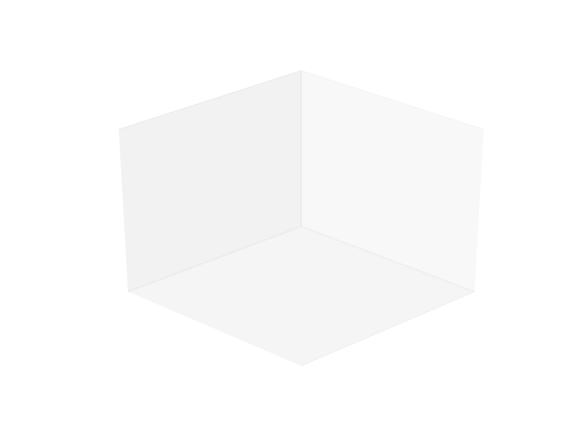

In [15]:
dt = 10 #時間幅
T_new = np.arange(0, T[-1], dt)
X_new = np.interp(T_new, T, X)
Y_new = np.interp(T_new, T, Y)
Z_new = np.interp(T_new, T, Z)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
L = 50 #空間のサイズ
def update(i):
    if i != 0:
        ax.clear()
    ax.scatter(0, 0, 0, marker="o", c="orange", s=100)
    ax.plot(X_new[:i], Y_new[:i], Z_new[:i], c="black", alpha = 0.4)
    ax.scatter(X_new[i], Y_new[i], Z_new[i], marker="o", c="blue", s=10)
    ax.set_title(r"$t=$"+str(int(T_new[i])))
    ax.view_init(elev=30, azim=225)
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_zlim(-L, L)

ani = animation.FuncAnimation(fig, update, frames=len(T_new), interval=1)